## Competition

https://www.kaggle.com/competitions/lmsys-chatbot-arena

**Description**

Large language models (LLMs) are rapidly entering our lives, but ensuring their responses resonate with users is critical for successful interaction. This competition presents a unique opportunity to tackle this challenge with real-world data and help us bridge the gap between LLM capability and human preference.

We utilized a large dataset collected from Chatbot Arena, where users chat with two anonymous LLMs and choose the answer they prefer. Your task in this competition is to predict which response a user will prefer in these head-to-head battles.

This challenge aligns with the concept of "reward models" or "preference models" in reinforcement learning from human feedback (RLHF). Previous research has identified limitations in directly prompting an existing LLM for preference predictions. These limitations often stem from biases such as favoring responses presented first (position bias), being overly verbose (verbosity bias), or exhibiting self-promotion (self-enhancement bias).

We encourage you to explore various machine-learning techniques to build a model that can effectively predict user preferences. Your work will be instrumental in developing LLMs that can tailor responses to individual user preferences, ultimately leading to more user-friendly and widely accepted AI-powered conversation systems.

In [ ]:
import gc
import os
import re
import numpy as np
import pandas as pd

import nltk
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

## Load data

In [ ]:
class config:
    root = "/kaggle/input/lmsys-chatbot-arena/"
    train_path = os.path.join(root, "train.csv")
    test_path = os.path.join(root, "test.csv")
    sample_submission_path = os.path.join(root, "sample_submission.csv")
    seed = 42
    n_splits = 10

In [ ]:
train = pd.read_csv(config.train_path)
test = pd.read_csv(config.test_path)
sample_submission = pd.read_csv(config.sample_submission_path)

if test.shape[0] < 10:
    train = train.iloc[:10000]

def process(input_str):
    stripped_str = input_str.strip('[]')
    sentences = [s.strip('"') for s in stripped_str.split('","')]
    return  ' '.join(sentences)

train["prompt"] = train["prompt"].apply(process)
train["response_a"] = train["response_a"].apply(process)
train["response_b"] = train["response_b"].apply(process)

test["prompt"] = test["prompt"].apply(process)
test["response_a"] = test["response_a"].apply(process)
test["response_b"] = test["response_b"].apply(process)

print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")
print("-"*90)
print(f"train missing values: {train.isnull().sum().sum()}")
print(f"test missing values: {test.isnull().sum().sum()}")
print("-"*90)

train.head()

train shape: (10000, 9)
test shape: (3, 4)
------------------------------------------------------------------------------------------
train missing values: 0
test missing values: 0
------------------------------------------------------------------------------------------


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0


In [ ]:
train_prompt = train["prompt"].to_numpy()
train_response_a = train["response_a"].to_numpy()
train_response_b = train["response_b"].to_numpy()

test_prompt = test["prompt"].to_numpy()
test_response_a = test["response_a"].to_numpy()
test_response_b = test["response_b"].to_numpy()

##  Feature-engineering the text data

Text cooding

In [ ]:
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np

def embeddings(df):
    # Объединяем все текстовые данные в один список
    text_data = df['prompt'].tolist() + df['response_a'].tolist() + df['response_b'].tolist()

    # Токенизация текста
    tokenized_data = [word_tokenize(text.lower()) for text in text_data]

    # Тренировка модели Word2Vec
    model = Word2Vec(sentences=tokenized_data, vector_size=500, window=5, min_count=1, workers=4)

    # Функция для получения вектора текста путем усреднения векторов слов
    def get_text_vector(text, model):
        words = word_tokenize(text.lower())
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if len(word_vectors) == 0:
            return np.zeros(model.vector_size)
        return np.mean(word_vectors, axis=0)

    # Применяем функцию для каждого текста в датафрейме
    df['prompt'] = df['prompt'].apply(lambda x: get_text_vector(x, model))
    df['response_a'] = df['response_a'].apply(lambda x: get_text_vector(x, model))
    df['response_b'] = df['response_b'].apply(lambda x: get_text_vector(x, model))

    return df


In [ ]:
train = embeddings(train)
test = embeddings(test)
train.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[0.14825033, 0.79692966, -0.17288265, -0.00606...","[0.21146363, 0.7052502, -0.23350675, -0.086343...","[0.17299703, 0.9479261, -0.31605896, -0.073043...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[-0.07025688, 0.9806348, -0.5844676, -0.174198...","[0.010892835, 0.9547029, -0.17581093, -0.13037...","[0.06697098, 0.8201421, -0.10287952, -0.131749...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[-0.39479163, 1.1118137, -0.6037361, -0.319885...","[0.05221387, 0.90780586, -0.17406768, -0.25018...","[-0.07777796, 0.84549266, -0.17828469, -0.2079...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[0.15107687, 0.8572051, -0.30020607, -0.016592...","[0.072249986, 0.9642767, -0.10863755, -0.15165...","[0.027496329, 1.023703, -0.14078672, -0.086771...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[-0.24248976, 0.8245399, -0.5598793, -0.248583...","[0.07269159, 0.9384141, -0.07560756, -0.053866...","[0.1793062, 0.8711123, -0.1420633, -0.08027805...",0,1,0


Cosine Similarity

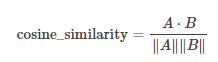

In [ ]:
def prep(data):
    def cosine_sim(text1, text2):
        response_a_vector = text1.apply(lambda x: np.array((x)))
        response_b_vector = text2.apply(lambda x: np.array((x)))
        cosine_similarities = [cosine_similarity([vec_a], [vec_b])[0][0] for vec_a, vec_b in zip(response_a_vector, response_b_vector)]
#         text1=np.array(text1)
#         text2=np.array(text2)
#         cos_sim = cosine_similarity(text1, text2)
        return cosine_similarities


    data["respa_respb_cosine_sim"] = cosine_sim(data["response_a"], data["response_b"])
    data["respa_prompt_cosine_sim"] = cosine_sim(data["response_a"], data["prompt"])
    data["respb_prompt_cosine_sim"] = cosine_sim(data["response_b"], data["prompt"])

    return data

In [ ]:
train = prep(train)
test = prep(test)
train.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,respa_respb_cosine_sim,respa_respb_jaccard_sim,respa_prompt_cosine_sim,respa_prompt_jaccard_sim,respb_prompt_cosine_sim,respb_prompt_jaccard_sim
0,30192,gpt-4-1106-preview,gpt-4-0613,"[0.14825033, 0.79692966, -0.17288265, -0.00606...","[0.21146363, 0.7052502, -0.23350675, -0.086343...","[0.17299703, 0.9479261, -0.31605896, -0.073043...",1,0,0,0.973350,0.0,0.922567,0.0,0.949712,0.0
1,53567,koala-13b,gpt-4-0613,"[-0.07025688, 0.9806348, -0.5844676, -0.174198...","[0.010892835, 0.9547029, -0.17581093, -0.13037...","[0.06697098, 0.8201421, -0.10287952, -0.131749...",0,1,0,0.990317,0.0,0.918969,0.0,0.920804,0.0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[-0.39479163, 1.1118137, -0.6037361, -0.319885...","[0.05221387, 0.90780586, -0.17406768, -0.25018...","[-0.07777796, 0.84549266, -0.17828469, -0.2079...",0,0,1,0.926621,0.0,0.773783,0.0,0.804028,0.0
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[0.15107687, 0.8572051, -0.30020607, -0.016592...","[0.072249986, 0.9642767, -0.10863755, -0.15165...","[0.027496329, 1.023703, -0.14078672, -0.086771...",1,0,0,0.974948,0.0,0.913226,0.0,0.907252,0.0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[-0.24248976, 0.8245399, -0.5598793, -0.248583...","[0.07269159, 0.9384141, -0.07560756, -0.053866...","[0.1793062, 0.8711123, -0.1420633, -0.08027805...",0,1,0,0.976064,0.0,0.795458,0.0,0.777366,0.0


Jaccard Similarity


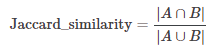



Generate N-grams¶

Description: N-grams are contiguous sequences of 'n' items from a given text. This method helps in analyzing the text at different levels of granularity (unigrams, bigrams, trigrams, etc.).


Count N-gram Overlaps

Description: This method calculates how many n-grams are common between two texts, helping to measure their similarity.

In [ ]:
def prep_extra(data,data0):

    def jaccard_sim(text1, text2):
        set1 = set(text1)
        set2 = set(text2)
        intersection = set1.intersection(set2)
        union = set1.union(set2)
        return len(intersection) / len(union)

    def tokenize(text):
        return nltk.word_tokenize(text.lower())

    def generate_ngrams(text, n: int):
        tokens = tokenize(text)
        return list(ngrams(tokens, n))

    def count_ngram_overlaps(text1, text2, n: int) -> int:
        try:
            ngrams1 = generate_ngrams(text1, n)
            ngrams2 = generate_ngrams(text2, n)
            counter1 = Counter(ngrams1)
            counter2 = Counter(ngrams2)
            overlap = counter1 & counter2
            overlap_count = sum(overlap.values())
            return overlap_count
        except:
            return 0


    data["respa_respb_jaccard_sim"] = data0.apply(lambda x: jaccard_sim(x["response_a"], x["response_b"]), axis=1)
    data["respa_prompt_jaccard_sim"] = data0.apply(lambda x: jaccard_sim(x["response_a"], x["prompt"]), axis=1)
    data["respb_prompt_jaccard_sim"] = data0.apply(lambda x: jaccard_sim(x["response_b"], x["prompt"]), axis=1)


    data["respa_len"] = data0["response_a"].apply(lambda x: len(tokenize(x)))
    data["respb_len"] = data0["response_b"].apply(lambda x: len(tokenize(x)))
    data["prompt_len"] = data0["prompt"].apply(lambda x: len(tokenize(x)))

    data["respa_prompt_len_ratio"] = data["respa_len"] / data["prompt_len"]
    data["respb_prompt_len_ratio"] = data["respb_len"] / data["prompt_len"]
    data["respa_respb_len_ratio"] = data["respa_len"] / data["respb_len"]

    data["respa_respb_len_diff"] = data["respa_len"] - data["respb_len"]
    data["respa_prompt_len_diff"] = data["respa_len"] - data["prompt_len"]
    data["respb_prompt_len_diff"] = data["respb_len"] - data["prompt_len"]

    data["respa_respb_overlap_unigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_a"], x["response_b"], 1), axis=1)
    data["respa_respb_overlap_bigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_a"], x["response_b"], 2), axis=1)
    data["respa_respb_overlap_trigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_a"], x["response_b"], 3), axis=1)

    data["respa_prompt_overlap_unigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_a"], x["prompt"], 1), axis=1)
    data["respa_prompt_overlap_bigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_a"], x["prompt"], 2), axis=1)
    data["respa_prompt_overlap_trigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_a"], x["prompt"], 3), axis=1)

    data["respb_prompt_overlap_unigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_b"], x["prompt"], 1), axis=1)
    data["respb_prompt_overlap_bigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_b"], x["prompt"], 2), axis=1)
    data["respb_prompt_overlap_trigram"] = data0.apply(lambda x: count_ngram_overlaps(x["response_b"], x["prompt"], 3), axis=1)


    data["respa_prompt_overlap_unigram_ratio"] = data["respa_prompt_overlap_unigram"] / data["prompt_len"]
    data["respa_prompt_overlap_bigram_ratio"] = data["respa_prompt_overlap_bigram"] / data["prompt_len"]
    data["respa_prompt_overlap_trigram_ratio"] = data["respa_prompt_overlap_trigram"] / data["prompt_len"]

    data["respb_prompt_overlap_unigram_ratio"] = data["respb_prompt_overlap_unigram"] / data["prompt_len"]
    data["respb_prompt_overlap_bigram_ratio"] = data["respb_prompt_overlap_bigram"] / data["prompt_len"]
    data["respb_prompt_overlap_trigram_ratio"] = data["respb_prompt_overlap_trigram"] / data["prompt_len"]
    return data

In [ ]:
train_0 = pd.read_csv(config.train_path)
test_0 = pd.read_csv(config.test_path)
sample_submission = pd.read_csv(config.sample_submission_path)

In [ ]:
train = prep_extra(train, train_0)
test = prep_extra(test, test_0)
train.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,respa_respb_cosine_sim,...,respa_prompt_overlap_trigram,respb_prompt_overlap_unigram,respb_prompt_overlap_bigram,respb_prompt_overlap_trigram,respa_prompt_overlap_unigram_ratio,respa_prompt_overlap_bigram_ratio,respa_prompt_overlap_trigram_ratio,respb_prompt_overlap_unigram_ratio,respb_prompt_overlap_bigram_ratio,respb_prompt_overlap_trigram_ratio
0,30192,gpt-4-1106-preview,gpt-4-0613,"[0.14825033, 0.79692966, -0.17288265, -0.00606...","[0.21146363, 0.7052502, -0.23350675, -0.086343...","[0.17299703, 0.9479261, -0.31605896, -0.073043...",1,0,0,0.973350,...,10,25,7,2,0.825000,0.425000,0.250000,0.625000,0.175000,0.050000
1,53567,koala-13b,gpt-4-0613,"[-0.07025688, 0.9806348, -0.5844676, -0.174198...","[0.010892835, 0.9547029, -0.17581093, -0.13037...","[0.06697098, 0.8201421, -0.10287952, -0.131749...",0,1,0,0.990317,...,6,36,15,5,0.734694,0.326531,0.122449,0.734694,0.306122,0.102041
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[-0.39479163, 1.1118137, -0.6037361, -0.319885...","[0.05221387, 0.90780586, -0.17406768, -0.25018...","[-0.07777796, 0.84549266, -0.17828469, -0.2079...",0,0,1,0.926621,...,1,11,5,1,0.800000,0.333333,0.066667,0.733333,0.333333,0.066667
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[0.15107687, 0.8572051, -0.30020607, -0.016592...","[0.072249986, 0.9642767, -0.10863755, -0.15165...","[0.027496329, 1.023703, -0.14078672, -0.086771...",1,0,0,0.974948,...,9,18,12,8,0.750000,0.500000,0.375000,0.750000,0.500000,0.333333
4,198779,koala-13b,gpt-3.5-turbo-0314,"[-0.24248976, 0.8245399, -0.5598793, -0.248583...","[0.07269159, 0.9384141, -0.07560756, -0.053866...","[0.1793062, 0.8711123, -0.1420633, -0.08027805...",0,1,0,0.976064,...,4,17,11,7,0.727273,0.409091,0.181818,0.772727,0.500000,0.318182


Unique words

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def unic_words_num(df, df_0):
    df['unique_words_response_a'] = df_0['response_a'].apply(lambda x: len(set(word_tokenize(x))))
    df['unique_words_response_b'] = df_0['response_b'].apply(lambda x: len(set(word_tokenize(x))))
    return df

In [ ]:
train = unic_words_num(train,train_0)
test = unic_words_num(test,test_0)
train.head()

,Unnamed: 0,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,...,respb_prompt_overlap_bigram,respb_prompt_overlap_trigram,respa_prompt_overlap_unigram_ratio,respa_prompt_overlap_bigram_ratio,respa_prompt_overlap_trigram_ratio,respb_prompt_overlap_unigram_ratio,respb_prompt_overlap_bigram_ratio,respb_prompt_overlap_trigram_ratio,unique_words_response_a,unique_words_response_b
0,0,30192,gpt-4-1106-preview,gpt-4-0613,[ 1.48250327e-01 7.96929657e-01 -1.72882646e-...,[ 2.11463630e-01 7.05250204e-01 -2.33506754e-...,[ 0.17299703 0.9479261 -0.31605896 -0.073043...,1,0,0,...,7,2,0.825000,0.425000,0.250000,0.625000,0.175000,0.050000,378,136
1,1,53567,koala-13b,gpt-4-0613,[-0.07025688 0.9806348 -0.5844676 -0.174198...,[ 1.08928354e-02 9.54702914e-01 -1.75810933e-...,[ 6.69709817e-02 8.20142090e-01 -1.02879517e-...,0,1,0,...,15,5,0.734694,0.326531,0.122449,0.734694,0.306122,0.102041,148,252
2,2,65089,gpt-3.5-turbo-0613,mistral-medium,[-0.39479163 1.1118137 -0.6037361 -0.319885...,[ 5.22138700e-02 9.07805860e-01 -1.74067676e-...,[-7.77779594e-02 8.45492661e-01 -1.78284690e-...,0,0,1,...,5,1,0.800000,0.333333,0.066667,0.733333,0.333333,0.066667,97,140
3,3,96401,llama-2-13b-chat,mistral-7b-instruct,[ 1.51076868e-01 8.57205093e-01 -3.00206065e-...,[ 7.22499862e-02 9.64276671e-01 -1.08637549e-...,[ 0.02749633 1.023703 -0.14078672 -0.086771...,1,0,0,...,12,8,0.750000,0.500000,0.375000,0.750000,0.500000,0.333333,169,119
4,4,198779,koala-13b,gpt-3.5-turbo-0314,[-2.42489755e-01 8.24539900e-01 -5.59879303e-...,[ 7.26915896e-02 9.38414097e-01 -7.56075606e-...,[ 1.79306194e-01 8.71112287e-01 -1.42063305e-...,0,1,0,...,11,7,0.727273,0.409091,0.181818,0.772727,0.500000,0.318182,125,82


Sentiment analysis of text

In [ ]:
from textblob import TextBlob
def sentment(df, df_0):
    df['sentiment_response_a'] = df_0['response_a'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['sentiment_response_b'] = df_0['response_b'].apply(lambda x: TextBlob(x).sentiment.polarity)
    return df

In [ ]:
train = sentment(train,train_0)
test = sentment(test,test_0)
train.head()

,Unnamed: 0,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,...,respa_prompt_overlap_unigram_ratio,respa_prompt_overlap_bigram_ratio,respa_prompt_overlap_trigram_ratio,respb_prompt_overlap_unigram_ratio,respb_prompt_overlap_bigram_ratio,respb_prompt_overlap_trigram_ratio,unique_words_response_a,unique_words_response_b,sentiment_response_a,sentiment_response_b
0,0,30192,gpt-4-1106-preview,gpt-4-0613,[ 1.48250327e-01 7.96929657e-01 -1.72882646e-...,[ 2.11463630e-01 7.05250204e-01 -2.33506754e-...,[ 0.17299703 0.9479261 -0.31605896 -0.073043...,1,0,0,...,0.825000,0.425000,0.250000,0.625000,0.175000,0.050000,378,136,0.088119,0.130147
1,1,53567,koala-13b,gpt-4-0613,[-0.07025688 0.9806348 -0.5844676 -0.174198...,[ 1.08928354e-02 9.54702914e-01 -1.75810933e-...,[ 6.69709817e-02 8.20142090e-01 -1.02879517e-...,0,1,0,...,0.734694,0.326531,0.122449,0.734694,0.306122,0.102041,148,252,0.054014,0.148230
2,2,65089,gpt-3.5-turbo-0613,mistral-medium,[-0.39479163 1.1118137 -0.6037361 -0.319885...,[ 5.22138700e-02 9.07805860e-01 -1.74067676e-...,[-7.77779594e-02 8.45492661e-01 -1.78284690e-...,0,0,1,...,0.800000,0.333333,0.066667,0.733333,0.333333,0.066667,97,140,0.276190,0.083333
3,3,96401,llama-2-13b-chat,mistral-7b-instruct,[ 1.51076868e-01 8.57205093e-01 -3.00206065e-...,[ 7.22499862e-02 9.64276671e-01 -1.08637549e-...,[ 0.02749633 1.023703 -0.14078672 -0.086771...,1,0,0,...,0.750000,0.500000,0.375000,0.750000,0.500000,0.333333,169,119,0.160765,0.230551
4,4,198779,koala-13b,gpt-3.5-turbo-0314,[-2.42489755e-01 8.24539900e-01 -5.59879303e-...,[ 7.26915896e-02 9.38414097e-01 -7.56075606e-...,[ 1.79306194e-01 8.71112287e-01 -1.42063305e-...,0,1,0,...,0.727273,0.409091,0.181818,0.772727,0.500000,0.318182,125,82,0.203846,0.252778


Topic Matching (LDA Topic Modeling)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def lda_sem(df,df_0):

    vectorizer = CountVectorizer()
    prompts_and_responses = df_0['prompt'] + df_0['response_a'] + df_0['response_b']
    X = vectorizer.fit_transform(prompts_and_responses)
    lda = LatentDirichletAllocation(n_components=10, random_state=0)
    lda.fit(X)

    def compute_topic_distribution(text):
        X_text = vectorizer.transform([text])
        return lda.transform(X_text)[0]

    df['topic_dist_prompt'] = df_0['prompt'].apply(lambda x: compute_topic_distribution(x))
    df['topic_dist_response_a'] = df_0['response_a'].apply(lambda x: compute_topic_distribution(x))
    df['topic_dist_response_b'] = df_0['response_b'].apply(lambda x: compute_topic_distribution(x))

    def compute_topic_similarity(prompt_dist, response_dist):
        return np.dot(prompt_dist, response_dist)

    df['topic_similarity_response_a'] = df.apply(lambda x: compute_topic_similarity(x['topic_dist_prompt'], x['topic_dist_response_a']), axis=1)
    df['topic_similarity_response_b'] = df.apply(lambda x: compute_topic_similarity(x['topic_dist_prompt'], x['topic_dist_response_b']), axis=1)

    return df


In [ ]:
train = lda_sem(train,train_0)
test = lda_sem(test,test_0)
train.head()

,Unnamed: 0,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,...,respb_prompt_overlap_trigram_ratio,unique_words_response_a,unique_words_response_b,sentiment_response_a,sentiment_response_b,topic_dist_prompt,topic_dist_response_a,topic_dist_response_b,topic_similarity_response_a,topic_similarity_response_b
0,0,30192,gpt-4-1106-preview,gpt-4-0613,[ 1.48250327e-01 7.96929657e-01 -1.72882646e-...,[ 2.11463630e-01 7.05250204e-01 -2.33506754e-...,[ 0.17299703 0.9479261 -0.31605896 -0.073043...,1,0,0,...,0.050000,378,136,0.088119,0.130147,"[0.0035714978733118663, 0.0035727873136843376,...","[0.0001512927458127778, 0.0001513316587953256,...","[0.0005128249931057372, 0.0005129812381744884,...",0.233883,0.270951
1,1,53567,koala-13b,gpt-4-0613,[-0.07025688 0.9806348 -0.5844676 -0.174198...,[ 1.08928354e-02 9.54702914e-01 -1.75810933e-...,[ 6.69709817e-02 8.20142090e-01 -1.02879517e-...,0,1,0,...,0.102041,148,252,0.054014,0.148230,"[0.0028571683318059948, 0.1196307424053573, 0....","[0.00019960265298000235, 0.0001996520964445076...","[0.00018182010195809362, 0.0001818721504973176...",0.211429,0.189571
2,2,65089,gpt-3.5-turbo-0613,mistral-medium,[-0.39479163 1.1118137 -0.6037361 -0.319885...,[ 5.22138700e-02 9.07805860e-01 -1.74067676e-...,[-7.77779594e-02 8.45492661e-01 -1.78284690e-...,0,0,1,...,0.066667,97,140,0.276190,0.083333,"[0.011111119650613451, 0.011113756375514684, 0...","[0.0007299331721190057, 0.19283552811787508, 0...","[0.00037736094612099885, 0.34884326722868747, ...",0.339641,0.276481
3,3,96401,llama-2-13b-chat,mistral-7b-instruct,[ 1.51076868e-01 8.57205093e-01 -3.00206065e-...,[ 7.22499862e-02 9.64276671e-01 -1.08637549e-...,[ 0.02749633 1.023703 -0.14078672 -0.086771...,1,0,0,...,0.333333,169,119,0.160765,0.230551,"[0.007142902955310745, 0.1781692153249614, 0.0...","[0.0001926795679706063, 0.2900806066283786, 0....","[0.0003773613411540632, 0.44263046156831554, 0...",0.206698,0.165479
4,4,198779,koala-13b,gpt-3.5-turbo-0314,[-2.42489755e-01 8.24539900e-01 -5.59879303e-...,[ 7.26915896e-02 9.38414097e-01 -7.56075606e-...,[ 1.79306194e-01 8.71112287e-01 -1.42063305e-...,0,1,0,...,0.318182,125,82,0.203846,0.252778,"[0.006251996931222836, 0.006253349836846019, 0...","[0.0004464660635576031, 0.000446573790425593, ...","[0.0007936915294493722, 0.0007938749223657878,...",0.243447,0.197438


In [ ]:
train.to_csv('train_fin.csv')

## Train

In [ ]:
drop_cols = ["id", "response_a", "response_b", "prompt", "topic_dist_prompt","topic_dist_response_a","topic_dist_response_b"]
# drop_cols = ["id"]
target_cols = ["winner_model_a", "winner_model_b", "winner_tie"]
target = "target"

train[target] = np.nan
for idx, t in enumerate(target_cols):
    train.loc[train[t] == 1, target] = idx
train[target] = train[target].astype("int32")

train.head()

,Unnamed: 0,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,...,unique_words_response_a,unique_words_response_b,sentiment_response_a,sentiment_response_b,topic_dist_prompt,topic_dist_response_a,topic_dist_response_b,topic_similarity_response_a,topic_similarity_response_b,target
0,0,30192,gpt-4-1106-preview,gpt-4-0613,[ 1.48250327e-01 7.96929657e-01 -1.72882646e-...,[ 2.11463630e-01 7.05250204e-01 -2.33506754e-...,[ 0.17299703 0.9479261 -0.31605896 -0.073043...,1,0,0,...,378,136,0.088119,0.130147,"[0.0035714978733118663, 0.0035727873136843376,...","[0.0001512927458127778, 0.0001513316587953256,...","[0.0005128249931057372, 0.0005129812381744884,...",0.233883,0.270951,0
1,1,53567,koala-13b,gpt-4-0613,[-0.07025688 0.9806348 -0.5844676 -0.174198...,[ 1.08928354e-02 9.54702914e-01 -1.75810933e-...,[ 6.69709817e-02 8.20142090e-01 -1.02879517e-...,0,1,0,...,148,252,0.054014,0.148230,"[0.0028571683318059948, 0.1196307424053573, 0....","[0.00019960265298000235, 0.0001996520964445076...","[0.00018182010195809362, 0.0001818721504973176...",0.211429,0.189571,1
2,2,65089,gpt-3.5-turbo-0613,mistral-medium,[-0.39479163 1.1118137 -0.6037361 -0.319885...,[ 5.22138700e-02 9.07805860e-01 -1.74067676e-...,[-7.77779594e-02 8.45492661e-01 -1.78284690e-...,0,0,1,...,97,140,0.276190,0.083333,"[0.011111119650613451, 0.011113756375514684, 0...","[0.0007299331721190057, 0.19283552811787508, 0...","[0.00037736094612099885, 0.34884326722868747, ...",0.339641,0.276481,2
3,3,96401,llama-2-13b-chat,mistral-7b-instruct,[ 1.51076868e-01 8.57205093e-01 -3.00206065e-...,[ 7.22499862e-02 9.64276671e-01 -1.08637549e-...,[ 0.02749633 1.023703 -0.14078672 -0.086771...,1,0,0,...,169,119,0.160765,0.230551,"[0.007142902955310745, 0.1781692153249614, 0.0...","[0.0001926795679706063, 0.2900806066283786, 0....","[0.0003773613411540632, 0.44263046156831554, 0...",0.206698,0.165479,0
4,4,198779,koala-13b,gpt-3.5-turbo-0314,[-2.42489755e-01 8.24539900e-01 -5.59879303e-...,[ 7.26915896e-02 9.38414097e-01 -7.56075606e-...,[ 1.79306194e-01 8.71112287e-01 -1.42063305e-...,0,1,0,...,125,82,0.203846,0.252778,"[0.006251996931222836, 0.006253349836846019, 0...","[0.0004464660635576031, 0.000446573790425593, ...","[0.0007936915294493722, 0.0007938749223657878,...",0.243447,0.197438,1


In [ ]:
X = train.drop(columns=target_cols+drop_cols+[target]+["model_a", "model_b"], axis=1)
y = train[target]
X_test = test.drop(columns=drop_cols, axis=1)

X = X.replace([-np.inf, np.inf], np.nan)
X_test = X_test.replace([-np.inf, np.inf], np.nan)

In [ ]:
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [ ]:
# Define models and their configurations
models = {
    'catboost': {
        'model': cb.CatBoostClassifier(
            loss_function='MultiClass',
            iterations=650,
            learning_rate=0.045,
            depth=5,
            random_seed=0,
#             task_type="GPU",  # Use GPU if available
            verbose=75
        ),
        'params': {}
    },
      # 'xgboost': {
      #         'model': xgb.XGBClassifier(
      #             objective='multi:softprob',
      #             num_class=3,
      #             eval_metric='mlogloss',
      #             subsample=0.8,
      #             n_estimators=650,
      #             learning_rate=0.045,
      #             max_depth=5,
      #             random_state=0,
      #             enable_categorical=True
      # #             tree_method='gpu_hist'  # GPU acceleration if available
      #         ),
      #         'params': {}
      #     },
}

# Select features using SelectKBest
selector = SelectKBest(f_classif, k=25)
X_new = selector.fit_transform(X, y)
X_test_new = selector.transform(X_test)

# X_new = X
# X_test_new = X_test

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Dataframe to store results
results = []

# Iterate over models
for model_name, model_data in models.items():
    model = model_data['model']
    print(f"Training model: {model_name}")

    test_preds = np.zeros(shape=(X_test_new.shape[0], y.nunique()))
    cv_scores = []

    for idx, (train_idx, val_idx) in enumerate(cv.split(X_new, y)):
        print(train_idx)
        X_train, y_train = X_new[train_idx], y[train_idx]
        X_val, y_val = X_new[val_idx], y[val_idx]
        # X_train, y_train = X_new.iloc[train_idx], y.iloc[train_idx]
        # X_val, y_val = X_new.iloc[val_idx], y.iloc[val_idx]

        if model_name == 'voting':
            model.fit(X_train, y_train)
        elif model_name == 'catboost':
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=75,
                verbose=75
            )
        else:
            model.fit(
                X_train,
                y_train
            )

        if model_name != 'voting':
            val_preds = model.predict_proba(X_val)
            val_log_loss = log_loss(y_val, val_preds, eps="auto")
            cv_scores.append(val_log_loss)

            test_preds += model.predict_proba(X_test_new) / cv.get_n_splits()

    if model_name != 'voting':
        mean_cv_log_loss = np.mean(cv_scores)
        results.append({'Model': model_name, 'CV_Log_Loss': mean_cv_log_loss})
        print(f"Mean CV Log Loss: {mean_cv_log_loss:.5f}")

# Store feature importances if applicable
if model_name in ['random_forest', 'gradient_boosting', 'xgboost', 'catboost']:
    features = X.columns[selector.get_support()].tolist()
    feat_imp_df = pd.DataFrame({"feature": features})
    feat_imp_df[f"{model_name}_avg_importance"] = 0

    for idx, (_, val_idx) in enumerate(cv.split(X_new, y)):
        X_val, _ = X_new[val_idx], y[val_idx]
        feat_imp_df[f"{model_name}_avg_importance"] += model.feature_importances_ / cv.get_n_splits()

    results_df = pd.DataFrame(results)
    results_df = pd.concat([results_df, feat_imp_df], axis=1)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best model
best_model = results_df.loc[results_df['CV_Log_Loss'].idxmin()]
print(f"\nBest Model:\n{best_model}")

# Display results DataFrame
print("\nResults DataFrame:")
print(results_df)

Training model: catboost
[   0    1    2 ... 9997 9998 9999]
0:	learn: 1.0951310	test: 1.0951310	test1: 1.0947605	best: 1.0947605 (0)	total: 64ms	remaining: 41.6s
75:	learn: 1.0285322	test: 1.0285322	test1: 1.0335303	best: 1.0335303 (75)	total: 652ms	remaining: 4.92s
150:	learn: 1.0126236	test: 1.0126236	test1: 1.0306083	best: 1.0305021 (147)	total: 1.23s	remaining: 4.07s
225:	learn: 0.9967792	test: 0.9967792	test1: 1.0305208	best: 1.0300543 (180)	total: 1.8s	remaining: 3.38s
Stopped by overfitting detector  (75 iterations wait)

bestTest = 1.030054337
bestIteration = 180

Shrink model to first 181 iterations.
[   0    1    3 ... 9997 9998 9999]
0:	learn: 1.0949456	test: 1.0949456	test1: 1.0953265	best: 1.0953265 (0)	total: 9.55ms	remaining: 6.2s
75:	learn: 1.0277761	test: 1.0277761	test1: 1.0443874	best: 1.0443874 (75)	total: 594ms	remaining: 4.49s
150:	learn: 1.0106914	test: 1.0106914	test1: 1.0415358	best: 1.0415358 (150)	total: 1.16s	remaining: 3.82s
225:	learn: 0.9957178	test: 0.9

In [ ]:
submission = pd.read_csv(config.sample_submission_path)

In [ ]:
for idx, t in enumerate(target_cols):
    submission[t] = test_preds[:, idx]
submission.head()

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.243833,0.344306,0.411861
1,211333,0.451736,0.212785,0.335479
2,1233961,0.406488,0.292166,0.301346


In [ ]:
submission.to_csv('submission.csv', index=False)